In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    586.975086
slp    408.364157
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.430437,1.645854,1.691689,1.761544,1.788436
gas_to_electricity_public,0.243006,0.410189,0.338406,0.347216,0.569568
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.1,91.1,91.1,91.1,91.1
manufacturing_sector,94.1,94.1,94.1,94.1,94.1
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'gas_to_electricity_public': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"

In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer == 'rlm':
        names += ['temp+econ']
    if consumer == 'power':
        names = ['naive']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['residential','commercial','time*residential','solar']
#        if 'temp' in name:
#            control_list += 'w2h','time*w2h','temp,'solar']
        if 'econ' in name:
            control_list += ['manu','prod'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'naive' in name:
            #control_list += ['temp','time*temp','solar','time*solar', "temp_inertia"]
            #control_list += ['temp_inertia']
            control_list = control_list
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [10]:
title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',  
        'power':'Power sector'  
}

In [11]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    if consumer != "power":
        i += 1
        ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
        ax.plot([i,i], [res['low'], res['high']], color=colors[-1])

    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    if consumer=='power': 
        labels = ['Overall\nchange']
    ax.set_xticks(range(len(results)) if consumer == "power" else range(len(results)+1))
    ax.set_xticklabels(labels if consumer == "power" else (labels + ['Crisis\nresponse']))

In [12]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry', 'power']
    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1,0.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')
    
    res = {m: extract_results(dummy_list, value) for m, value in results['power'].items()}
    ax3 = plot_waterfall(ax3, res, 'power')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


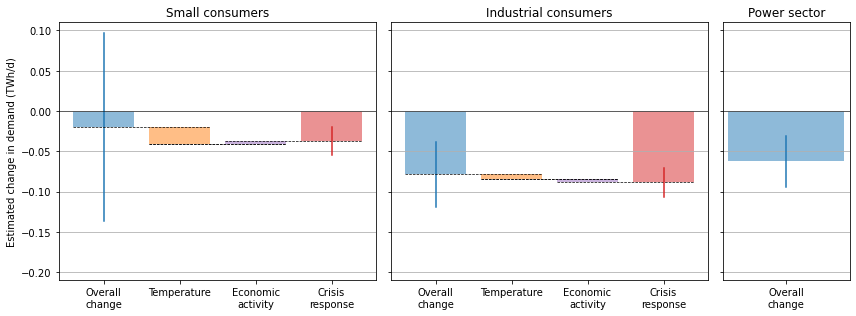

In [13]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.21, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [14]:
#results['industry']['temp+econ'].summary()
#results['slp']['temp+econ'].summary()
results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     79.86
Date:                Fri, 15 Jul 2022   Prob (F-statistic):          1.85e-221
Time:                        18:04:24   Log-Likelihood:                 1532.5
No. Observations:                1788   AIC:                            -3025.
Df Residuals:                    1768   BIC:                            -2915.
Df Model:                          19                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4798      0.022     22.305      0.000       0.438       0.522
C(month)[T.2]              -0.0340      0.024     -1.441      0.150      -0.080       0.012
C(month)[T.3]              -0.0819      0.023     -3.607      0.000      -0.126      -0.037
C(month)[T.4]              -0.1398      0.023     -6.006      0.000      -0.185      -0.094
C(month)[T.5]              -0.1862      0.021     -9.049      0.000      -0.226      -0.146
C(month)[T.6]              -0.1713      0.021     -8.050      0.000      -0.213      -0.130
C(month)[T.7]              -0.1544      0.022     -6.908      0.000      -0.198      -0.111
C(month)[T.8]              -0.1658      0.022     -7.554      0.000      -0.209      -0.123
C(month)[T.9]              -0.1458      0.024     -6.186      0.000      -0.192      -0.100
C(month)[T.10]             -0.1203      0.023     -5.327      0.000      -0.165      -0.076
C(month)[T.11]             -0.0189      0.024     -0.799      0.424      -0.065       0.027
C(month)[T.12]              0.0078      0.029      0.269      0.788      -0.049       0.065
C(weekday)[T.Monday]       -0.0015      0.008     -0.186      0.853      -0.018       0.015
C(weekday)[T.Saturday]     -0.1182      0.006    -19.703      0.000      -0.130      -0.106
C(weekday)[T.Sunday]       -0.1600      0.007    -22.515      0.000      -0.174      -0.146
C(weekday)[T.Thursday]      0.0221      0.006      3.437      0.001       0.009       0.035
C(weekday)[T.Tuesday]       0.0263      0.008      3.106      0.002       0.010       0.043
C(weekday)[T.Wednesday]     0.0194      0.008      2.410      0.016       0.004       0.035
crisis[T.True]             -0.0623      0.016     -3.928      0.000      -0.093      -0.031
time                     3.693e-05   1.02e-05      3.635      0.000     1.7e-05    5.68e-05
==============================================================================
Omnibus:                        2.809   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.868
Skew:                           0.088   Prob(JB):                        0.238
Kurtosis:                       2.913   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# year-on-year
for con, mod  in [('industry','temp+econ'),('slp','temp+econ'),('power','naive')]:
    
    crisis_coefficient = -results[con][mod].params["crisis[T.True]"]
    ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')][con].mean()  #, (338+58)/(338+141+58))
    print(
          title_conversion[con] + ": " + str(round(crisis_coefficient,4)) + " TWh/d " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. demand during months 8-3 before crisis"+ "\n" 
         )

Industrial consumers: 0.0887 TWh/d 
which is 7 % of 1.3603 TWh/d avg. demand during months 8-3 before crisis

Small consumers: 0.0373 TWh/d 
which is 3 % of 1.386 TWh/d avg. demand during months 8-3 before crisis

Power sector: 0.0623 TWh/d 
which is 14 % of 0.4425 TWh/d avg. demand during months 8-3 before crisis



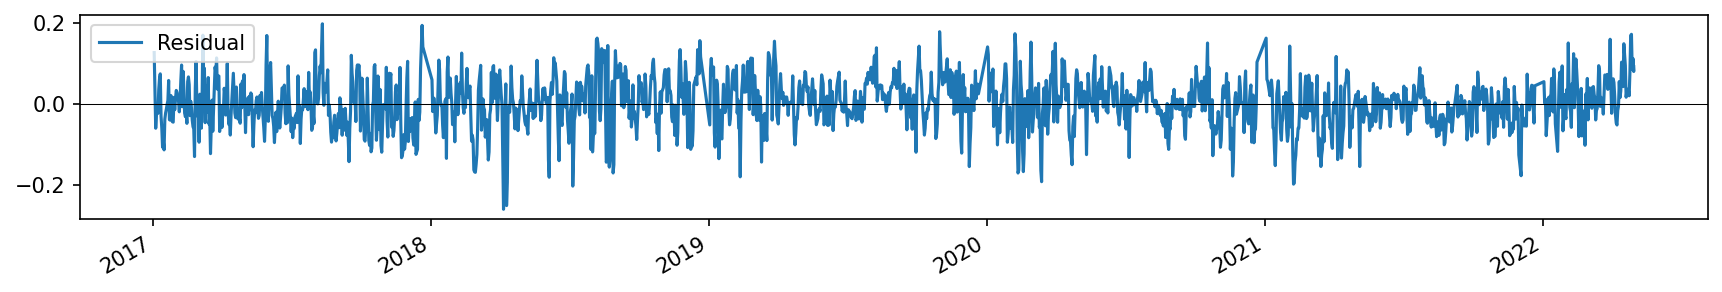

In [16]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

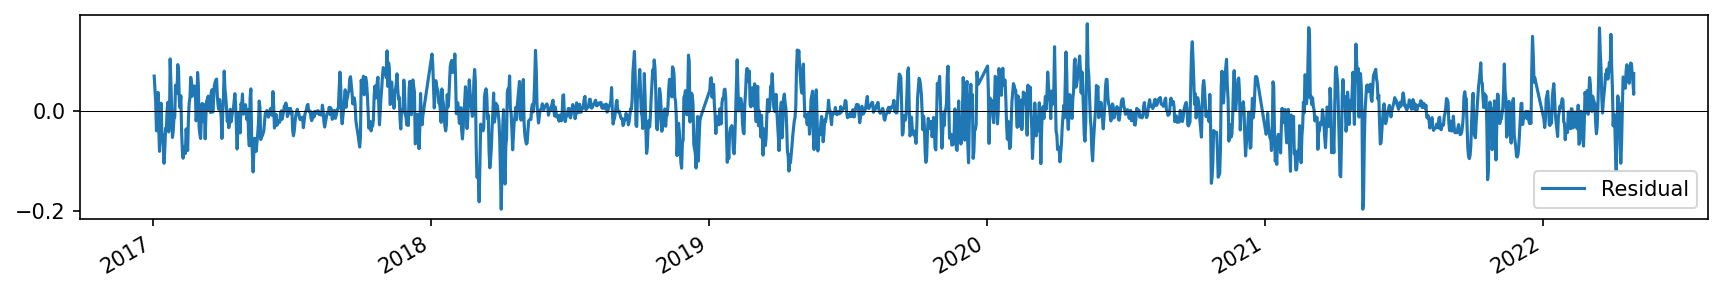

In [17]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

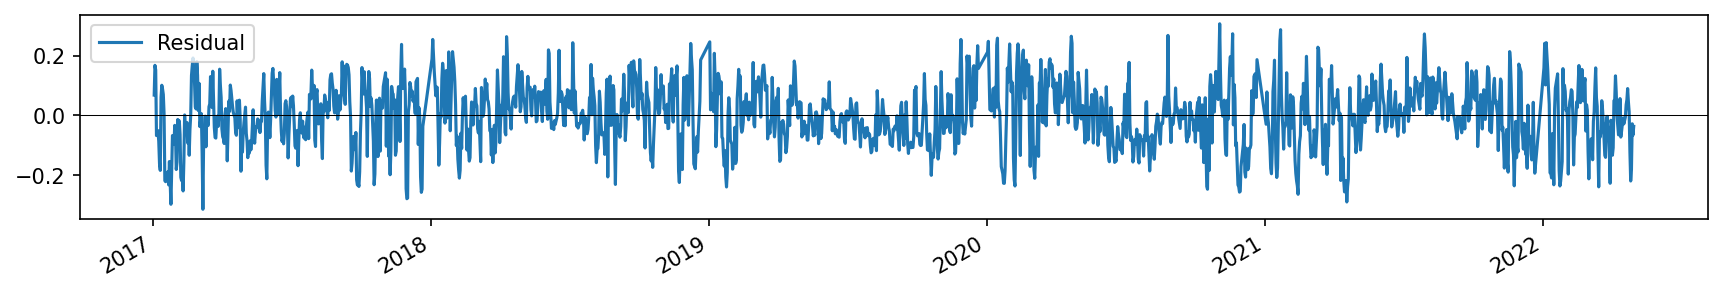

In [18]:
resid = results['power']['naive'].fittedvalues - dfx['power'] 

plt.figure(figsize=(14, 2), dpi=150)

resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

## Sensitivities

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industrial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

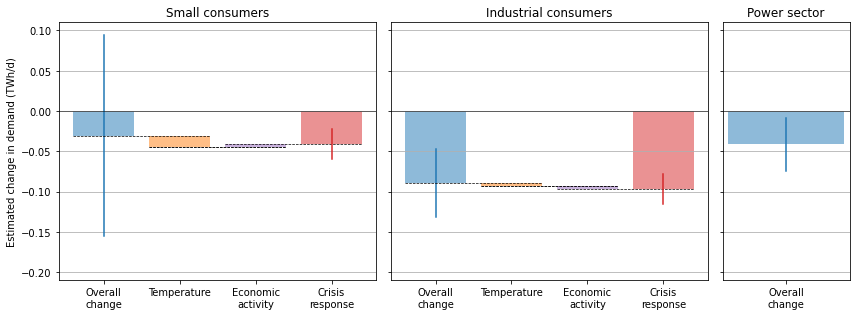

In [19]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

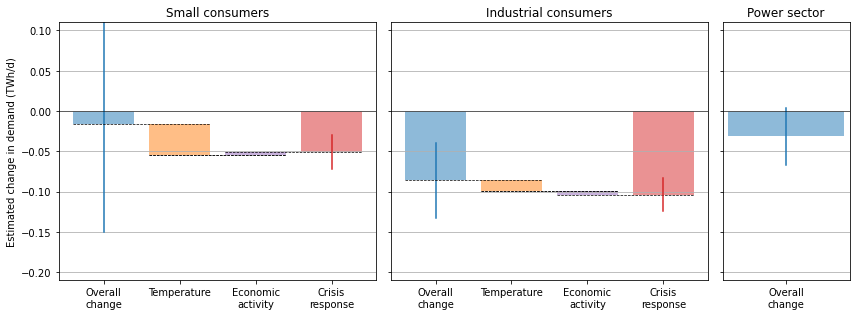

In [20]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-10-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

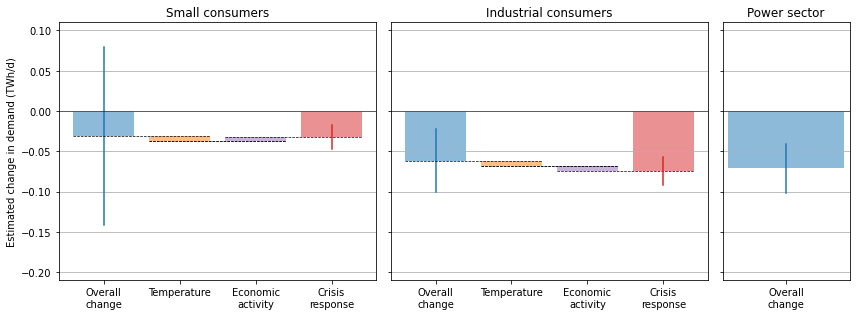

In [21]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-06-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

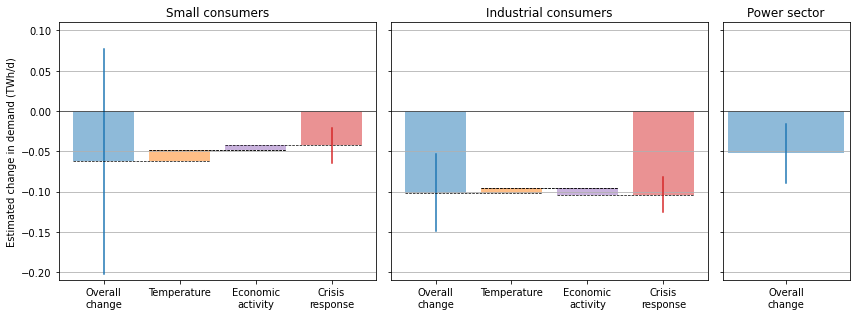

In [22]:
log=False
fitting_start = "2018-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

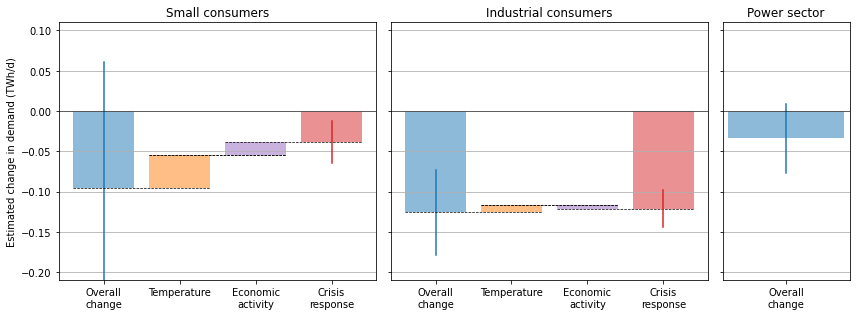

In [23]:
log=False
fitting_start = "2019-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.25, 0.11)

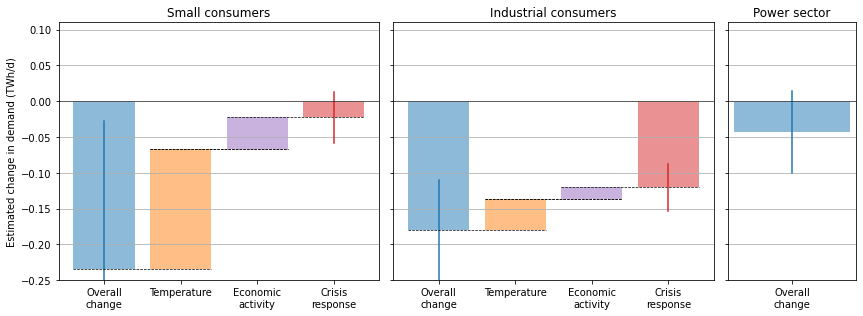

In [24]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.25, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
power ~ 1 + time + C(month) + C(weekday) + crisis


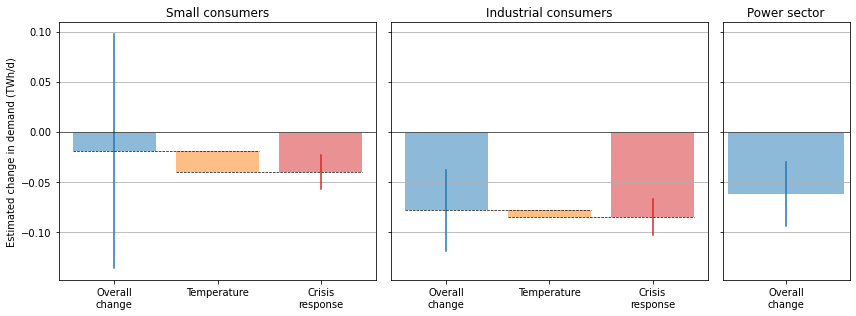

In [25]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False)

# Quarterly dummies (not currently used)

In [26]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx[dummy_name] = dfx.index.map( 
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [27]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [28]:
def plot_monthly(ax, results, consumer='industry', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='industry' else 'tab:red'),
        'power': 'tab:green'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.2, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',
        'power': "Power sector"
    }
    ax.set_title(title_conversion[consumer])
   
    ax.set_xticks(
        range(len(res)), 
    #    [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
    #     for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    ax.set_xticklabels(
        [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
         for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [29]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
in

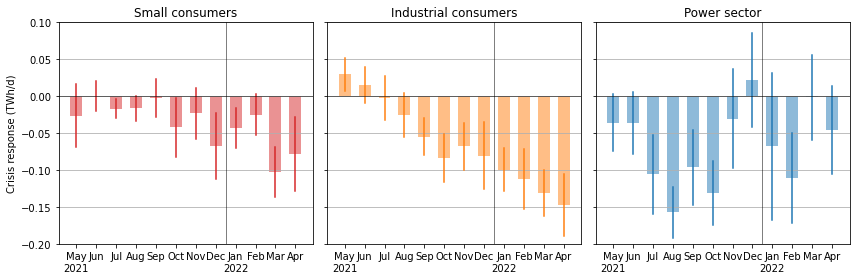

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plot_monthly(ax3, results, "power", names=['naive'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [31]:
#results['industry']['temp+econ'].summary()
results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     64.62
Date:                Fri, 15 Jul 2022   Prob (F-statistic):          5.36e-258
Time:                        18:04:35   Log-Likelihood:                 1576.4
No. Observations:                1788   AIC:                            -3091.
Df Residuals:                    1757   BIC:                            -2921.
Df Model:                          30                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4718      0.024     19.742      0.000       0.425       0.519
C(month)[T.2]              -0.0272      0.027     -1.027      0.304      -0.079       0.025
C(month)[T.3]              -0.0936      0.025     -3.736      0.000      -0.143      -0.044
C(month)[T.4]              -0.1445      0.026     -5.513      0.000      -0.196      -0.093
C(month)[T.5]              -0.1794      0.023     -7.806      0.000      -0.224      -0.134
C(month)[T.6]              -0.1646      0.024     -6.940      0.000      -0.211      -0.118
C(month)[T.7]              -0.1343      0.023     -5.801      0.000      -0.180      -0.089
C(month)[T.8]              -0.1480      0.023     -6.319      0.000      -0.194      -0.102
C(month)[T.9]              -0.1407      0.027     -5.233      0.000      -0.193      -0.088
C(month)[T.10]             -0.1082      0.025     -4.322      0.000      -0.157      -0.059
C(month)[T.11]             -0.0272      0.026     -1.029      0.303      -0.079       0.025
C(month)[T.12]             -0.0100      0.032     -0.317      0.751      -0.072       0.052
C(weekday)[T.Monday]       -0.0017      0.008     -0.203      0.839      -0.018       0.014
C(weekday)[T.Saturday]     -0.1183      0.006    -19.739      0.000      -0.130      -0.107
C(weekday)[T.Sunday]       -0.1604      0.007    -22.657      0.000      -0.174      -0.146
C(weekday)[T.Thursday]      0.0221      0.006      3.421      0.001       0.009       0.035
C(weekday)[T.Tuesday]       0.0259      0.008      3.069      0.002       0.009       0.042
C(weekday)[T.Wednesday]     0.0193      0.008      2.394      0.017       0.004       0.035
d2021_5[T.True]            -0.0355      0.019     -1.830      0.067      -0.073       0.003
d2021_6[T.True]            -0.0359      0.021     -1.700      0.089      -0.077       0.005
d2021_7[T.True]            -0.1057      0.027     -3.978      0.000      -0.158      -0.054
d2021_8[T.True]            -0.1569      0.017     -8.980      0.000      -0.191      -0.123
d2021_9[T.True]            -0.0960      0.026     -3.759      0.000      -0.146      -0.046
d2021_10[T.True]           -0.1309      0.022     -5.980      0.000      -0.174      -0.088
d2021_11[T.True]           -0.0302      0.033     -0.908      0.364      -0.095       0.035
d2021_12[T.True]            0.0226      0.032      0.712      0.476      -0.040       0.085
d2022_1[T.True]            -0.0674      0.050     -1.360      0.174      -0.165       0.030
d2022_2[T.True]            -0.1102      0.031     -3.603      0.000      -0.170      -0.050
d2022_3[T.True]            -0.0015      0.029     -0.053      0.958      -0.058       0.055
d2022_4[T.True]            -0.0453      0.030     -1.517      0.129      -0.104       0.013
time                     4.664e-05   1.16e-05  

In [32]:
log=True
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry']}

log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar + hosp + retail
log_industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
log_industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*re

In [33]:
extracted_results = pd.DataFrame()

for consumer in ['industry','slp']:
    extracted_results[consumer] = results[consumer]['temp+econ'].params
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]

extracted_results.index = dummy_list

##ToDo: calculate monthly elasticities

#resprice = pd.read_csv(os.path.join(data_path, 'Erdgas_Preisentwicklung_BDEW.csv'), index_col=0, parse_dates=True)['Gas price']
#resprice = resprice.loc[resprice.index > crisis_start]
#resprice.index = dummy_list
#extracted_results['resprice'] = resprice
                         
#ttfd = pd.read_csv(os.path.join(data_path, 'gas_prices_TTF.csv'), index_col=0, parse_dates=True)['Price']
#ttf = ttfd.resample('1m', label='left').mean()
#ttf.index = ttfd.index + pd.Timedelta('1d')
#ttf = ttf.loc[ttf.index > crisis_start]
#ttf.index = dummy_list
#extracted_results['ttf'] = ttf
                   
extracted_results.index = dummy_list
extracted_results

,industry,slp
d2021_5,0.032083,0.128163
d2021_6,0.018219,-0.075959
d2021_7,0.001799,-0.060931
d2021_8,-0.025144,0.091556
d2021_9,-0.054759,-0.077399
d2021_10,-0.063630,0.001884
d2021_11,-0.048202,-0.052985
d2021_12,-0.058806,-0.082725
d2022_1,-0.064241,-0.003771
d2022_2,-0.073256,0.025347
